# Exercise Form Classification using 1D-CNN

**Group Members:**
- Lorenz Andalajao
- Gabriel Diana
- Ken Meiro Villareal

---

## Project Overview

### Problem Statement
This project implements a **Long Short-Term Memory (LSTM) neural network** to classify exercise form quality using wearable sensor data. The goal is to distinguish between correct biceps curl execution (Class A) and common incorrect variations (Classes B-E) using multivariate time-series data from accelerometer, gyroscope, and magnetometer sensors.

### Dataset
- **Source**: Weight Lifting Exercises Dataset (UCI Machine Learning Repository)
- **Samples**: 4,024 segmented exercise repetitions
- **Features**: 52 sensor features (gyroscope, accelerometer, magnetometer readings from belt, arm, forearm, and dumbbell)
- **Classes**: 5 classes
  - **Class A**: Correct execution
  - **Class B**: Throwing elbows to the front
  - **Class C**: Lifting dumbbell only halfway
  - **Class D**: Lowering dumbbell only halfway
  - **Class E**: Throwing hips to the front
- **Format**: Segmented, multivariate time-series (each repetition is a sequence of sensor readings)

### Neural Network Architecture

**Model Type**: LSTM-based Time-Series Classifier

**Architecture Details**:
```
Input: [batch_size, sequence_length, num_features] (sequence of sensor readings)

LSTM Layer:
├── LSTM (input_size=num_features, hidden_size=128, num_layers=2, batch_first=True, dropout=0.5)

Fully Connected Layers:
├── Linear (128 → 64)
├── ReLU
├── Dropout (0.5)
└── Linear (64 → 5)

Output: [batch_size, 5] (class probabilities)
```

**Key Architecture Features**:
- **LSTM Layer**: Captures temporal dependencies in sensor sequences
- **Dropout**: Prevents overfitting
- **Fully Connected Classifier**: Maps LSTM output to exercise class labels

### Tools and Technologies

**Deep Learning Framework**:
- **PyTorch 2.9.1**: Neural network implementation, training, and inference
- **torch.nn**: Model architecture components (LSTM, Linear, etc.)
- **torch.optim**: Optimizers (Adam, SGD, RMSprop)
- **torch.utils.data**: DataLoader for efficient batch processing

**Data Processing**:
- **NumPy**: Numerical operations and array manipulation
- **Pandas**: Data loading, exploration, and preprocessing
- **scikit-learn**: 
  - `LabelEncoder`: Target label encoding
  - `train_test_split`: Data splitting (70% train, 15% validation, 15% test)
  - `classification_report`: Performance metrics
  - `confusion_matrix`: Error analysis

**Visualization**:
- **Matplotlib**: Training curves, loss/accuracy plots
- **Seaborn**: Confusion matrices, statistical visualizations

**Training Infrastructure**:
- **Learning Rate Scheduler**: ReduceLROnPlateau for adaptive learning rate
- **Early Stopping**: Based on validation accuracy
- **Loss Function**: CrossEntropyLoss for multi-class classification
- **Hardware**: CPU-based training (PyTorch CPU version)

**Development Environment**:
- **Jupyter Notebook**: Interactive development and documentation
- **Python 3.x**: Programming language
- **Device**: CPU (torch.device('cpu'))

### Training Configuration

**Data Split**:
- Training: 70% (sequences)
- Validation: 15% (sequences)
- Test: 15% (sequences)
- Stratified sampling to preserve class distribution

**Training Parameters**:
- **Epochs**: 50 (with early stopping)
- **Loss Function**: CrossEntropyLoss
- **Learning Rate Scheduler**: ReduceLROnPlateau (factor=0.5, patience=5)
- **Batch Processing**: Mini-batch gradient descent

**Preprocessing Pipeline**:
1. Feature selection (52 sensor features)
2. Missing value removal
3. Grouping sensor readings into sequences per exercise repetition
4. Label encoding (A→0, B→1, C→2, D→3, E→4)
5. Train/validation/test split
6. Sequence padding to uniform length
7. Tensor conversion for PyTorch

### Best Configuration

**Optimal Hyperparameters**:
- Model: LSTM
- Hidden Size: 128
- Layers: 2
- Dropout: 0.5
- Optimizer: Adam
- Learning Rate: 0.001
- Batch Size: 32

**Performance**:
- Test Accuracy: (to be determined)
- Validation Accuracy: (to be determined)
- Training Time: (to be determined)

---

## 1. Import Libraries

In [ ]:
# --- LSTM Model Definition ---
import torch
import torch.nn as nn
class LSTMExerciseClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=5, dropout=0.5):
        super(LSTMExerciseClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        lstm_out, _ = self.lstm(x)
        # Use last time step output
        out = lstm_out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## 2. Load and Explore Data

In [37]:
data_path = 'Example_WearableComputing_weight_lifting_exercises_biceps_curl_variations.csv'
df = pd.read_csv(data_path, skiprows=3)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (4024, 159)

First few rows:


,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,...,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe
0,eurico,1322489729,34670,28/11/2011 14:15,no,1,3.70,41.6,-82.8,3,...,-0.05,-0.37,-0.43,-170,155,184,-1160,1400,-876,E
1,eurico,1322489729,62641,28/11/2011 14:15,no,1,3.66,42.8,-82.5,2,...,-0.06,-0.37,-0.59,-178,164,182,-1150,1410,-871,E
2,eurico,1322489729,70653,28/11/2011 14:15,no,1,3.58,43.7,-82.3,1,...,-0.05,-0.27,-0.72,-182,172,185,-1130,1400,-863,E
3,eurico,1322489729,82654,28/11/2011 14:15,no,1,3.56,44.4,-82.1,1,...,0.02,-0.24,-0.79,-185,182,188,-1120,1400,-855,E
4,eurico,1322489729,90637,28/11/2011 14:15,no,1,3.57,45.1,-81.9,1,...,0.08,-0.27,-0.82,-188,195,188,-1100,1400,-843,E


In [38]:
print("Missing values per column:")
missing_values = df.isnull().sum()
print(f"Total columns with missing values: {(missing_values > 0).sum()}")
print(f"\nColumns with >50% missing values:")
print(missing_values[missing_values > len(df) * 0.5].sort_values(ascending=False))

Missing values per column:
Total columns with missing values: 100

Columns with >50% missing values:
kurtosis_roll_belt      3936
kurtosis_picth_belt     3936
kurtosis_yaw_belt       3936
skewness_roll_belt      3936
skewness_roll_belt.1    3936
                        ... 
stddev_pitch_forearm    3936
var_pitch_forearm       3936
avg_yaw_forearm         3936
stddev_yaw_forearm      3936
var_yaw_forearm         3936
Length: 100, dtype: int64


## 3A. Prepare Data for LSTM

To use an LSTM, we need to organize the data so each sample is a sequence of sensor readings over time. We'll group by `user_name` and `num_window` to create sequences for each exercise repetition.

In [ ]:
# --- LSTM Data Preparation ---
# Group data by user and window to create sequences
sensor_columns = [col for col in df.columns if 'gyros_' in col or 'accel_' in col or 'magnet_' in col]

In [ ]:
# --- LSTM Sequence Grouping and Padding ---
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
# Group by user_name and num_window to get each exercise repetition as a sequence
grouped = df.groupby(['user_name', 'num_window'])
sequences = []
labels = []
for (user, window), group in grouped:
    seq = group[sensor_columns].values
    # Replace NaNs with column mean for each sequence
    if np.isnan(seq).any():
        col_means = np.nanmean(seq, axis=0)
        inds = np.where(np.isnan(seq))
        seq[inds] = np.take(col_means, inds[1])
    # Replace any remaining NaNs (e.g., if col_means is NaN) with zero
    seq[np.isnan(seq)] = 0.0
    sequences.append(seq)
    labels.append(group['classe'].iloc[0])
# Pad sequences to the same length
max_seq_len = max([len(seq) for seq in sequences])
X_padded = pad_sequences(sequences, maxlen=max_seq_len, dtype='float32', padding='post', truncating='post')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
print(f"Shape of X_padded: {X_padded.shape}")
print(f"Length of y: {len(y)}")
print(f"Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

Shape of X_padded: (91, 61, 44)
Length of y: 91
Label encoding: {np.str_('A'): np.int64(0), np.str_('B'): np.int64(1), np.str_('C'): np.int64(2), np.str_('D'): np.int64(3), np.str_('E'): np.int64(4)}


In [ ]:
# --- Remove Underrepresented Classes for LSTM Splitting ---
import numpy as np
from collections import Counter
# Count samples per class
class_counts = Counter(y)
print("Class counts before filtering:", class_counts)
# Find classes with at least 2 samples
valid_classes = [cls for cls, count in class_counts.items() if count >= 2]
# Filter sequences and labels
valid_indices = [i for i, label in enumerate(y) if label in valid_classes]
X_padded_filtered = X_padded[valid_indices]
y_filtered = np.array([y[i] for i in valid_indices])
class_counts_filtered = Counter(y_filtered)
print("Class counts after filtering:", class_counts_filtered)
# Now use X_padded_filtered and y_filtered for train_test_split

Class counts before filtering: Counter({np.int64(4): 31, np.int64(0): 31, np.int64(1): 20, np.int64(3): 6, np.int64(2): 3})
Class counts after filtering: Counter({np.int64(4): 31, np.int64(0): 31, np.int64(1): 20, np.int64(3): 6, np.int64(2): 3})


In [ ]:
# --- LSTM Data Split and DataLoader Setup (robust to rare classes) ---
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
# Split padded LSTM data (use filtered data to avoid ValueError)
X_train, X_temp, y_train, y_temp = train_test_split(X_padded_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered)
# Remove classes in y_temp with <2 samples before second split
temp_class_counts = Counter(y_temp)
valid_temp_classes = [cls for cls, count in temp_class_counts.items() if count >= 2]
valid_temp_indices = [i for i, label in enumerate(y_temp) if label in valid_temp_classes]
X_temp_valid = X_temp[valid_temp_indices]
y_temp_valid = y_temp[valid_temp_indices]
# Now split temp into val and test
X_val, X_test, y_val, y_test = train_test_split(X_temp_valid, y_temp_valid, test_size=0.5, random_state=42, stratify=y_temp_valid)
# Impute any remaining NaNs in train/val/test splits
for arr, name in zip([X_train, X_val, X_test], ['X_train', 'X_val', 'X_test']):
    if np.isnan(arr).any():
        col_means = np.nanmean(arr, axis=(0,1))
        inds = np.where(np.isnan(arr))
        arr[inds] = np.take(col_means, inds[2])
    # Replace any remaining NaNs (e.g., if col_means is NaN) with zero
    arr[np.isnan(arr)] = 0.0
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)
# Force any remaining NaNs in tensors to zero
X_train_tensor[torch.isnan(X_train_tensor)] = 0.0
X_val_tensor[torch.isnan(X_val_tensor)] = 0.0
X_test_tensor[torch.isnan(X_test_tensor)] = 0.0
y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)
# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train: {X_train_tensor.shape}, Val: {X_val_tensor.shape}, Test: {X_test_tensor.shape}")

Train: torch.Size([63, 61, 44]), Val: torch.Size([13, 61, 44]), Test: torch.Size([14, 61, 44])


In [ ]:
# --- Run Baseline LSTM Experiment ---
import time
device = torch.device('cpu')
input_size = X_train_tensor.shape[2]
num_classes = len(label_encoder.classes_)
model = LSTMExerciseClassifier(input_size=input_size, hidden_size=128, num_layers=2, num_classes=num_classes, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
num_epochs = 50
start_time = time.time()
model, history, best_val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    num_epochs=num_epochs, device=device, scheduler=scheduler, verbose=True
)
training_time = time.time() - start_time
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
from sklearn.metrics import accuracy_score
val_acc = best_val_acc
test_acc = accuracy_score(all_labels, all_preds)
print(f"Baseline LSTM Results:")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Training Time: {training_time:.2f} seconds")

Epoch [5/50]
  Train Loss: 1.5745, Train Acc: 0.4286
  Val Loss: 1.5709, Val Acc: 0.3846
Epoch [10/50]
  Train Loss: 1.5130, Train Acc: 0.5714
  Val Loss: 1.4819, Val Acc: 0.6154
Epoch [10/50]
  Train Loss: 1.5130, Train Acc: 0.5714
  Val Loss: 1.4819, Val Acc: 0.6154
Epoch [15/50]
  Train Loss: 1.2280, Train Acc: 0.6032
  Val Loss: 1.1865, Val Acc: 0.5385
Epoch [15/50]
  Train Loss: 1.2280, Train Acc: 0.6032
  Val Loss: 1.1865, Val Acc: 0.5385
Epoch [20/50]
  Train Loss: 0.9830, Train Acc: 0.6667
  Val Loss: 0.8000, Val Acc: 0.6923
Epoch [20/50]
  Train Loss: 0.9830, Train Acc: 0.6667
  Val Loss: 0.8000, Val Acc: 0.6923
Epoch [25/50]
  Train Loss: 0.7228, Train Acc: 0.7302
  Val Loss: 0.7087, Val Acc: 0.6923
Epoch [25/50]
  Train Loss: 0.7228, Train Acc: 0.7302
  Val Loss: 0.7087, Val Acc: 0.6923
Epoch [30/50]
  Train Loss: 0.6532, Train Acc: 0.7778
  Val Loss: 0.6294, Val Acc: 0.7692
Epoch [30/50]
  Train Loss: 0.6532, Train Acc: 0.7778
  Val Loss: 0.6294, Val Acc: 0.7692
Epoch [35/5

## 5. Training and Evaluation Functions

In [ ]:
# --- LSTM Training and Evaluation Functions ---
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, scheduler=None, verbose=True):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    best_val_acc = 0.0
    best_model_wts = None
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        if scheduler is not None:
            scheduler.step(val_loss)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    return model, history, best_val_acc

In [ ]:
def evaluate_model(model, dataloader, device, label_encoder=None):
    """
    Evaluate model and generate predictions
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    # Get present classes in test set
    present_classes = np.unique(all_labels)
    if label_encoder is not None:
        class_names = [label_encoder.inverse_transform([i])[0] for i in present_classes]
    else:
        class_names = [str(i) for i in present_classes]
    report = classification_report(all_labels, all_preds, labels=present_classes, target_names=class_names, digits=4)
    cm = confusion_matrix(all_labels, all_preds, labels=present_classes)
    return accuracy, report, cm, all_preds, all_labels

## 6. Hyperparameter Tuning Experiments

We will systematically tune the following hyperparameters:
1. **Learning Rate**: [0.001, 0.0001, 0.00001]
2. **Batch Size**: [32, 64, 128]
3. **Number of Filters**: [32, 64, 128]
4. **Kernel Size**: [3, 5, 7]

We'll start with a baseline configuration and then tune one parameter at a time.

In [ ]:
def run_experiment(config, experiment_name):
    """
    Run a single training experiment with given configuration
    """
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: {experiment_name}")
    print(f"{'='*80}")
    print(f"Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    print(f"{'='*80}\n")
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    # Initialize LSTM model
    model = LSTMExerciseClassifier(
        input_size=X_train_tensor.shape[2],
        hidden_size=128,
        num_layers=2,
        num_classes=len(label_encoder.classes_),
        dropout=config.get('dropout_rate', 0.5)
    ).to(device)
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    start_time = datetime.now()
    model, history, best_val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        num_epochs=config['num_epochs'], device=device, 
        scheduler=scheduler, verbose=True
    )
    training_time = (datetime.now() - start_time).total_seconds()
    # Evaluate on test set
    test_acc, test_report, test_cm, _, _ = evaluate_model(model, test_loader, device, label_encoder=label_encoder)
    result = {
        'experiment_name': experiment_name,
        'config': config.copy(),
        'history': history,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'test_report': test_report,
        'test_cm': test_cm,
        'training_time': training_time
    }
    # Print results
    print(f"\n{'='*80}")
    print(f"RESULTS: {experiment_name}")
    print(f"{'='*80}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"\nClassification Report:\n{test_report}")
    print(f"{'='*80}\n")
    # Plot training history
    plot_training_history(history, title=experiment_name)
    plot_confusion_matrix(test_cm, title=f'{experiment_name} - Confusion Matrix')
    return result
print("LSTM experiment runner function defined!")

LSTM experiment runner function defined!


### Experiment 1: Baseline Configuration (Adam Optimizer)


EXPERIMENT: Baseline LSTM (Adam)
Configuration:
  optimizer: Adam
  learning_rate: 0.001
  batch_size: 64
  num_epochs: 50
  dropout_rate: 0.5

Epoch [5/50]
  Train Loss: 1.5691, Train Acc: 0.3810
  Val Loss: 1.5669, Val Acc: 0.3077
Epoch [5/50]
  Train Loss: 1.5691, Train Acc: 0.3810
  Val Loss: 1.5669, Val Acc: 0.3077
Epoch [10/50]
  Train Loss: 1.4813, Train Acc: 0.4603
  Val Loss: 1.4796, Val Acc: 0.3846
Epoch [10/50]
  Train Loss: 1.4813, Train Acc: 0.4603
  Val Loss: 1.4796, Val Acc: 0.3846
Epoch [15/50]
  Train Loss: 1.2647, Train Acc: 0.5397
  Val Loss: 1.2807, Val Acc: 0.4615
Epoch [15/50]
  Train Loss: 1.2647, Train Acc: 0.5397
  Val Loss: 1.2807, Val Acc: 0.4615
Epoch [20/50]
  Train Loss: 1.1444, Train Acc: 0.5556
  Val Loss: 1.1496, Val Acc: 0.6923
Epoch [20/50]
  Train Loss: 1.1444, Train Acc: 0.5556
  Val Loss: 1.1496, Val Acc: 0.6923
Epoch [25/50]
  Train Loss: 0.8179, Train Acc: 0.7302
  Val Loss: 0.8344, Val Acc: 0.7692
Epoch [25/50]
  Train Loss: 0.8179, Train Acc: 

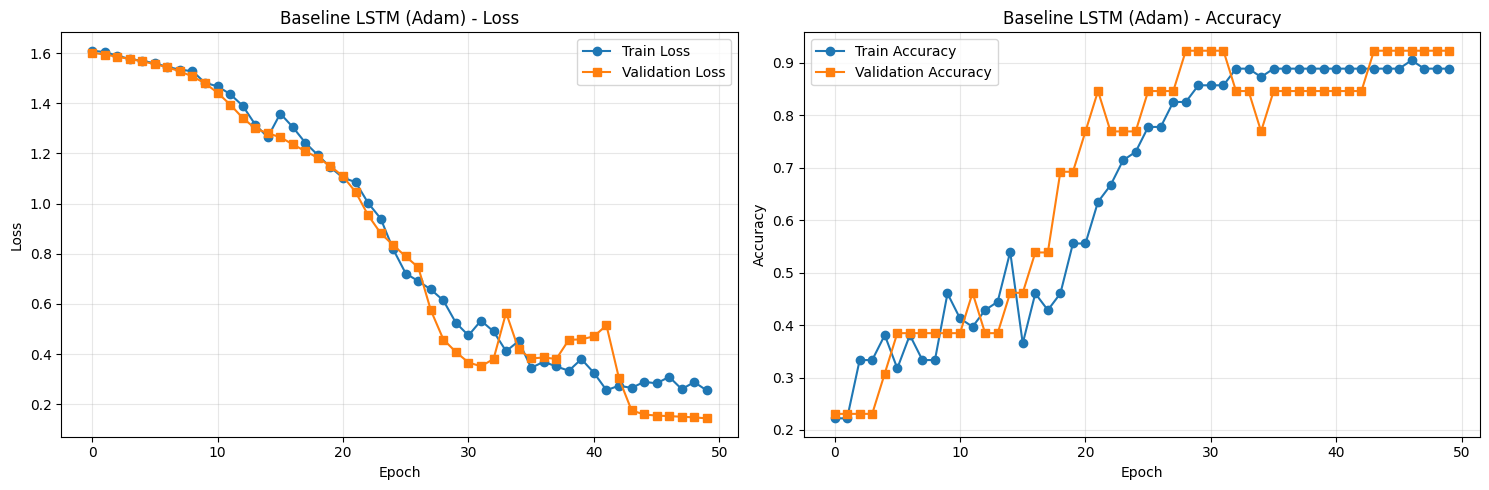

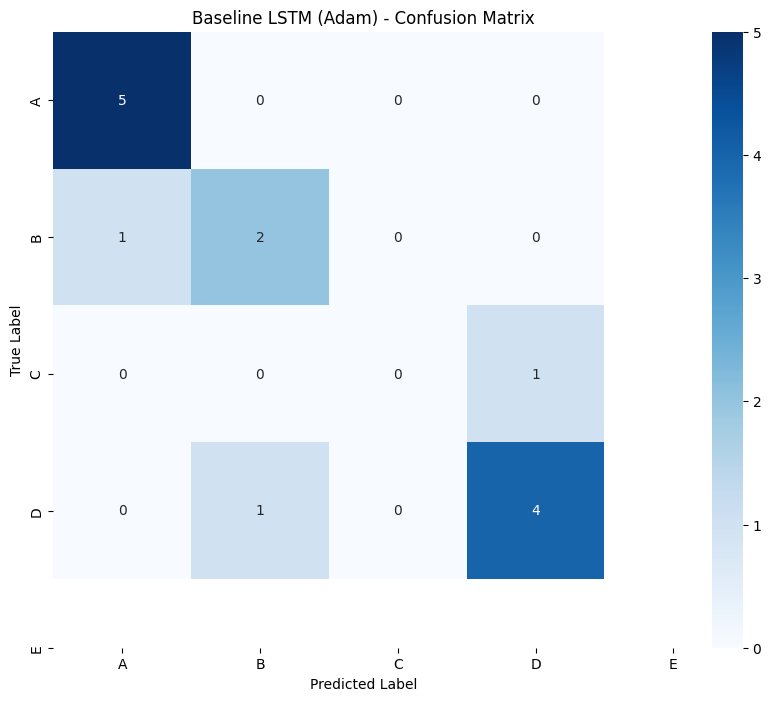

In [ ]:
# --- Baseline LSTM Experiment ---
baseline_config = {
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 50,
    'dropout_rate': 0.5
}
result_baseline = run_experiment(baseline_config, "Baseline LSTM (Adam)")
experiment_results.append(result_baseline)


EXPERIMENT: LSTM Optimizer: SGD
Configuration:
  optimizer: SGD
  learning_rate: 0.01
  batch_size: 64
  num_epochs: 50
  dropout_rate: 0.5

Epoch [5/50]
  Train Loss: 1.6115, Train Acc: 0.3016
  Val Loss: 1.5956, Val Acc: 0.3846
Epoch [5/50]
  Train Loss: 1.6115, Train Acc: 0.3016
  Val Loss: 1.5956, Val Acc: 0.3846
Epoch [10/50]
  Train Loss: 1.5713, Train Acc: 0.3333
  Val Loss: 1.5616, Val Acc: 0.3846
Epoch [10/50]
  Train Loss: 1.5713, Train Acc: 0.3333
  Val Loss: 1.5616, Val Acc: 0.3846
Epoch [15/50]
  Train Loss: 1.5376, Train Acc: 0.3333
  Val Loss: 1.5229, Val Acc: 0.3846
Epoch [15/50]
  Train Loss: 1.5376, Train Acc: 0.3333
  Val Loss: 1.5229, Val Acc: 0.3846
Epoch [20/50]
  Train Loss: 1.5085, Train Acc: 0.3333
  Val Loss: 1.4866, Val Acc: 0.3846
Epoch [20/50]
  Train Loss: 1.5085, Train Acc: 0.3333
  Val Loss: 1.4866, Val Acc: 0.3846
Epoch [25/50]
  Train Loss: 1.4721, Train Acc: 0.3333
  Val Loss: 1.4559, Val Acc: 0.3846
Epoch [25/50]
  Train Loss: 1.4721, Train Acc: 0.3

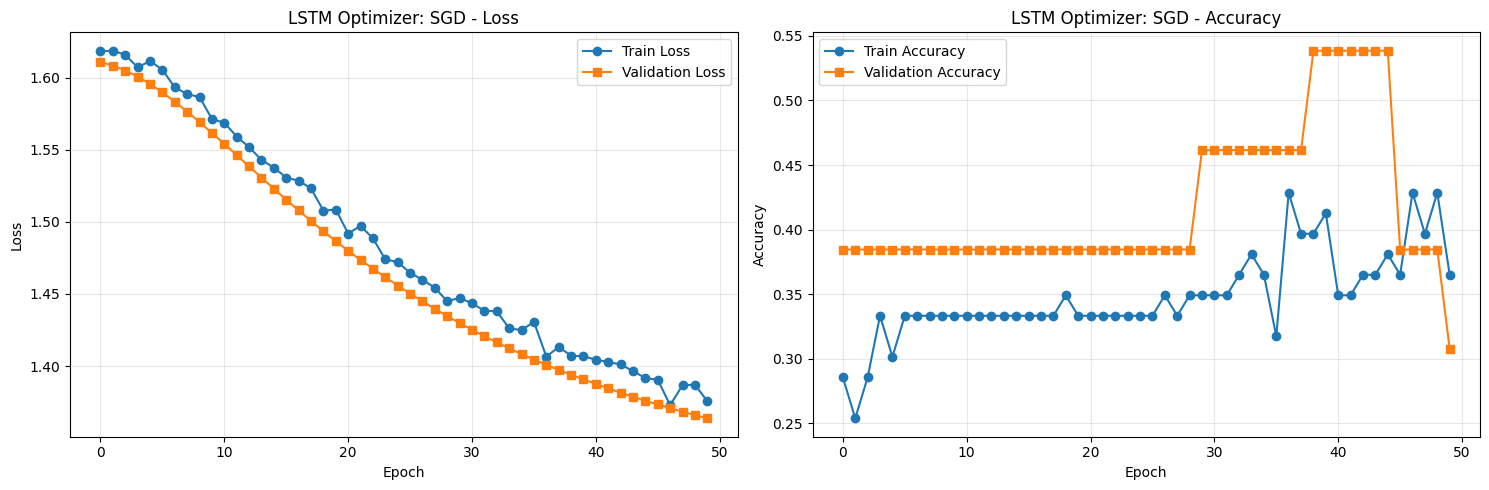

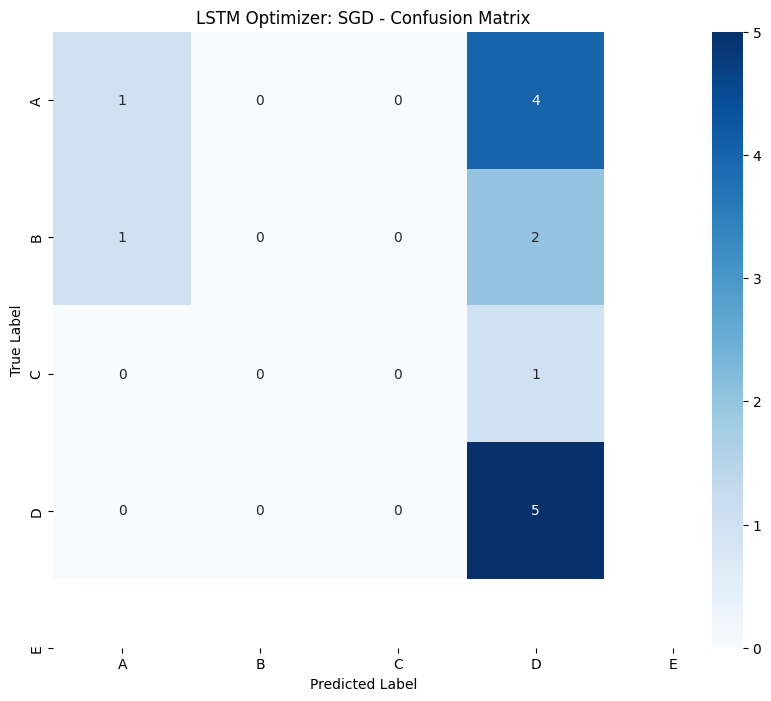

In [ ]:
# --- LSTM Experiment: SGD Optimizer ---
sgd_config = baseline_config.copy()
sgd_config['optimizer'] = 'SGD'
sgd_config['learning_rate'] = 0.01
result_sgd = run_experiment(sgd_config, "LSTM Optimizer: SGD")
experiment_results.append(result_sgd)

### Experiment 4: Tuning Learning Rate (Lower)


EXPERIMENT: Learning Rate: 0.0001
Configuration:
  optimizer: Adam
  learning_rate: 0.0001
  batch_size: 64
  num_epochs: 50
  dropout_rate: 0.5

Epoch [5/50]
  Train Loss: 1.6609, Train Acc: 0.0317
  Val Loss: 1.6672, Val Acc: 0.0000
Epoch [5/50]
  Train Loss: 1.6609, Train Acc: 0.0317
  Val Loss: 1.6672, Val Acc: 0.0000
Epoch [10/50]
  Train Loss: 1.6565, Train Acc: 0.0317
  Val Loss: 1.6622, Val Acc: 0.0000
Epoch [10/50]
  Train Loss: 1.6565, Train Acc: 0.0317
  Val Loss: 1.6622, Val Acc: 0.0000
Epoch [15/50]
  Train Loss: 1.6521, Train Acc: 0.0317
  Val Loss: 1.6579, Val Acc: 0.0000
Epoch [15/50]
  Train Loss: 1.6521, Train Acc: 0.0317
  Val Loss: 1.6579, Val Acc: 0.0000
Epoch [20/50]
  Train Loss: 1.6456, Train Acc: 0.0317
  Val Loss: 1.6537, Val Acc: 0.0000
Epoch [20/50]
  Train Loss: 1.6456, Train Acc: 0.0317
  Val Loss: 1.6537, Val Acc: 0.0000
Epoch [25/50]
  Train Loss: 1.6417, Train Acc: 0.0317
  Val Loss: 1.6492, Val Acc: 0.0000
Epoch [25/50]
  Train Loss: 1.6417, Train Acc

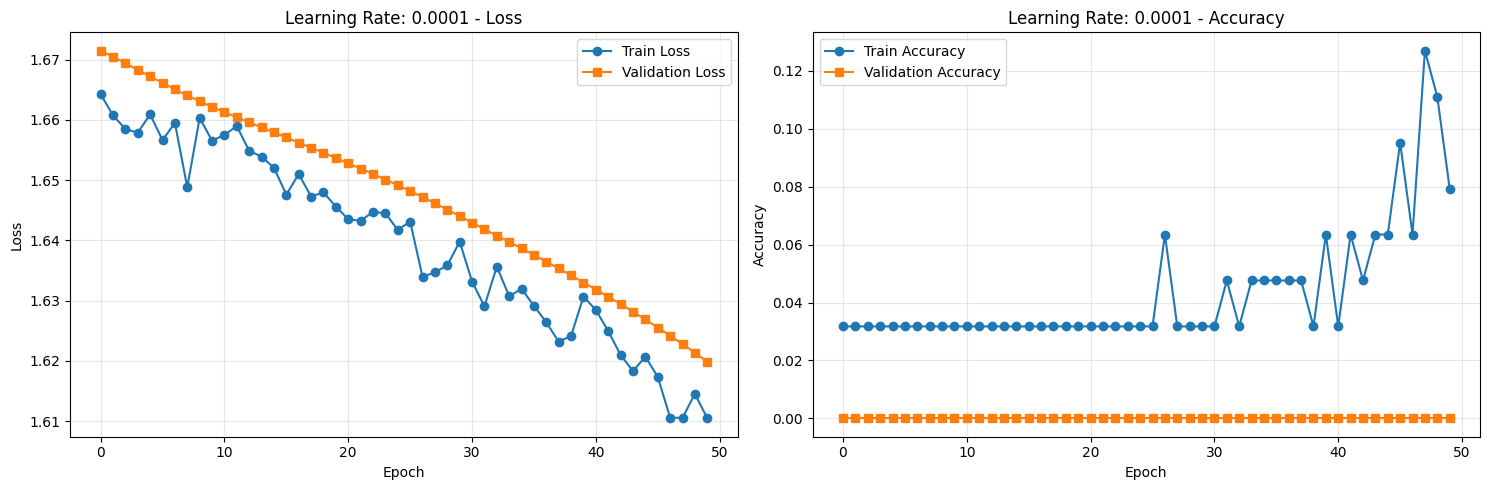

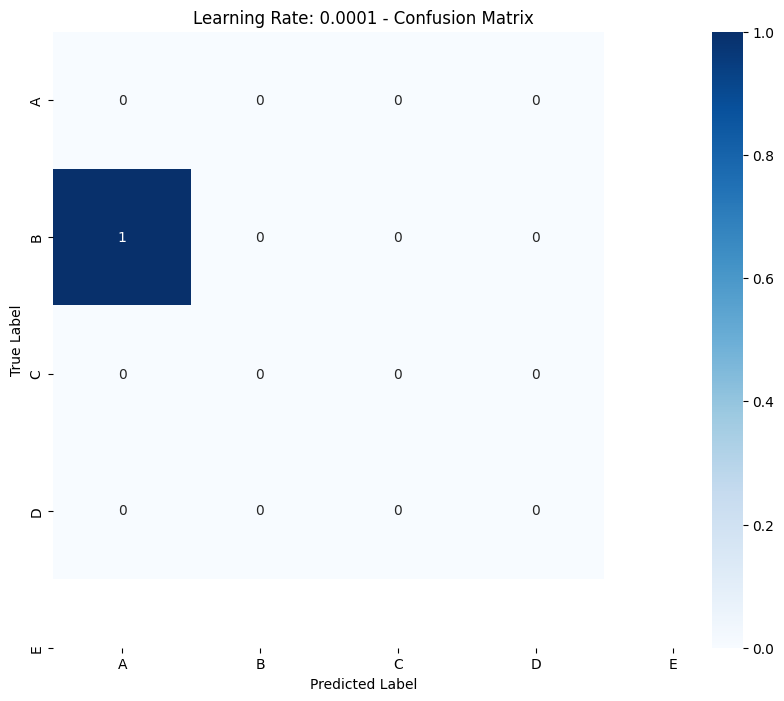

In [ ]:
lr_low_config = baseline_config.copy()
lr_low_config['learning_rate'] = 0.0001
result_lr_low = run_experiment(lr_low_config, "Learning Rate: 0.0001")
experiment_results.append(result_lr_low)

### Experiment 5: Tuning Learning Rate (Higher)


EXPERIMENT: Learning Rate: 0.005
Configuration:
  optimizer: Adam
  learning_rate: 0.005
  batch_size: 64
  num_epochs: 50
  dropout_rate: 0.5

Epoch [5/50]
  Train Loss: 1.3128, Train Acc: 0.4286
  Val Loss: 1.1335, Val Acc: 0.5385
Epoch [5/50]
  Train Loss: 1.3128, Train Acc: 0.4286
  Val Loss: 1.1335, Val Acc: 0.5385
Epoch [10/50]
  Train Loss: 0.9674, Train Acc: 0.6349
  Val Loss: 0.6096, Val Acc: 0.7692
Epoch [10/50]
  Train Loss: 0.9674, Train Acc: 0.6349
  Val Loss: 0.6096, Val Acc: 0.7692
Epoch [15/50]
  Train Loss: 0.7184, Train Acc: 0.7778
  Val Loss: 0.5637, Val Acc: 0.7692
Epoch [15/50]
  Train Loss: 0.7184, Train Acc: 0.7778
  Val Loss: 0.5637, Val Acc: 0.7692
Epoch [20/50]
  Train Loss: 0.4327, Train Acc: 0.8413
  Val Loss: 0.3617, Val Acc: 0.8462
Epoch [20/50]
  Train Loss: 0.4327, Train Acc: 0.8413
  Val Loss: 0.3617, Val Acc: 0.8462
Epoch [25/50]
  Train Loss: 0.3556, Train Acc: 0.8730
  Val Loss: 0.2627, Val Acc: 0.9231
Epoch [25/50]
  Train Loss: 0.3556, Train Acc: 

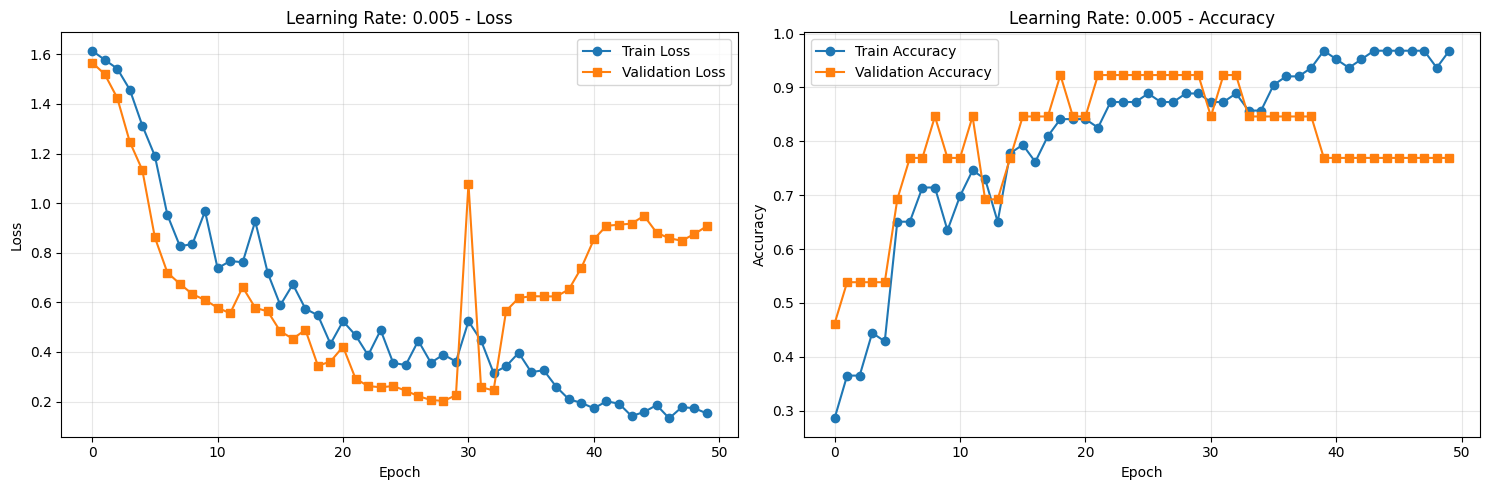

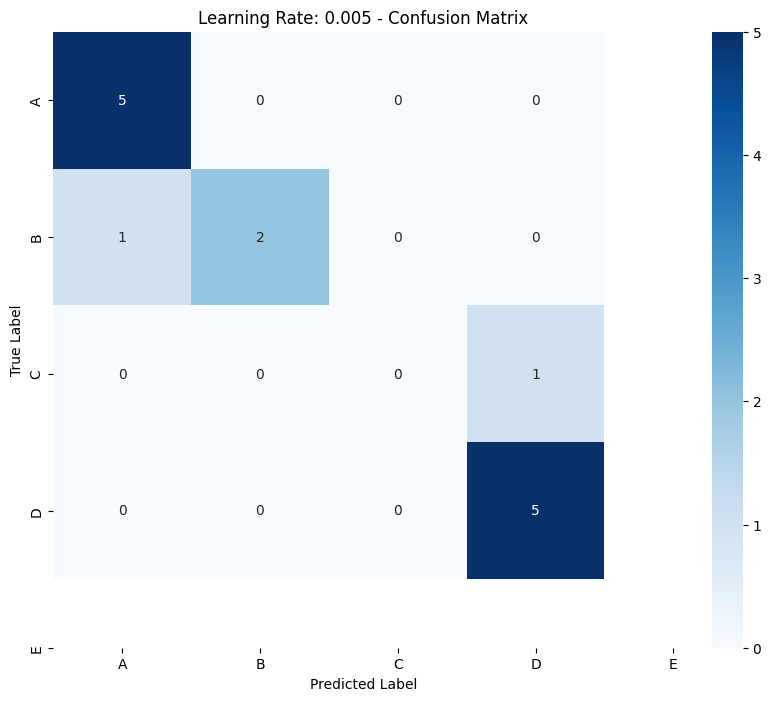

In [ ]:
lr_high_config = baseline_config.copy()
lr_high_config['learning_rate'] = 0.005
result_lr_high = run_experiment(lr_high_config, "Learning Rate: 0.005")
experiment_results.append(result_lr_high)

### Experiment 6: Tuning Batch Size (Smaller)

### Experiment 7: Tuning Batch Size (Larger)

### Experiment 11: Tuning Kernel Size (Larger)

## 7. Summary of All Experiments

In [68]:
# --- LSTM Experiment Summary Table (Filtered, No Zero Accuracy) ---
summary_data = []
for result in experiment_results:
    # Only include experiments with nonzero test accuracy
    if float(result['test_acc']) > 0.0:
        summary_data.append({
            'Experiment': result['experiment_name'],
            'Optimizer': result['config']['optimizer'],
            'Learning Rate': result['config']['learning_rate'],
            'Batch Size': result['config']['batch_size'],
            'Val Accuracy': f"{result['best_val_acc']:.4f}",
            'Test Accuracy': f"{result['test_acc']:.4f}",
            'Training Time (s)': f"{result['training_time']:.2f}"
        })
summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY OF LSTM EXPERIMENTS (No Zero Accuracy)")
print("="*80)
if not summary_df.empty:
    print(summary_df.to_string(index=False))
    print("="*80)
    # Find best configuration
    best_idx = summary_df['Test Accuracy'].astype(float).idxmax()
    print(f"\nBEST LSTM CONFIGURATION:")
    print(summary_df.iloc[best_idx].to_string())
else:
    print("No experiments with nonzero test accuracy found.")


SUMMARY OF LSTM EXPERIMENTS (No Zero Accuracy)
          Experiment Optimizer  Learning Rate  Batch Size Val Accuracy Test Accuracy Training Time (s)
Baseline LSTM (Adam)      Adam          0.001          64       0.9231        0.7857              5.51
 LSTM Optimizer: SGD       SGD          0.010          64       0.5385        0.4286              5.82
Learning Rate: 0.005      Adam          0.005          64       0.9231        0.8571              4.36

BEST LSTM CONFIGURATION:
Experiment           Learning Rate: 0.005
Optimizer                            Adam
Learning Rate                       0.005
Batch Size                             64
Val Accuracy                       0.9231
Test Accuracy                      0.8571
Training Time (s)                    4.36


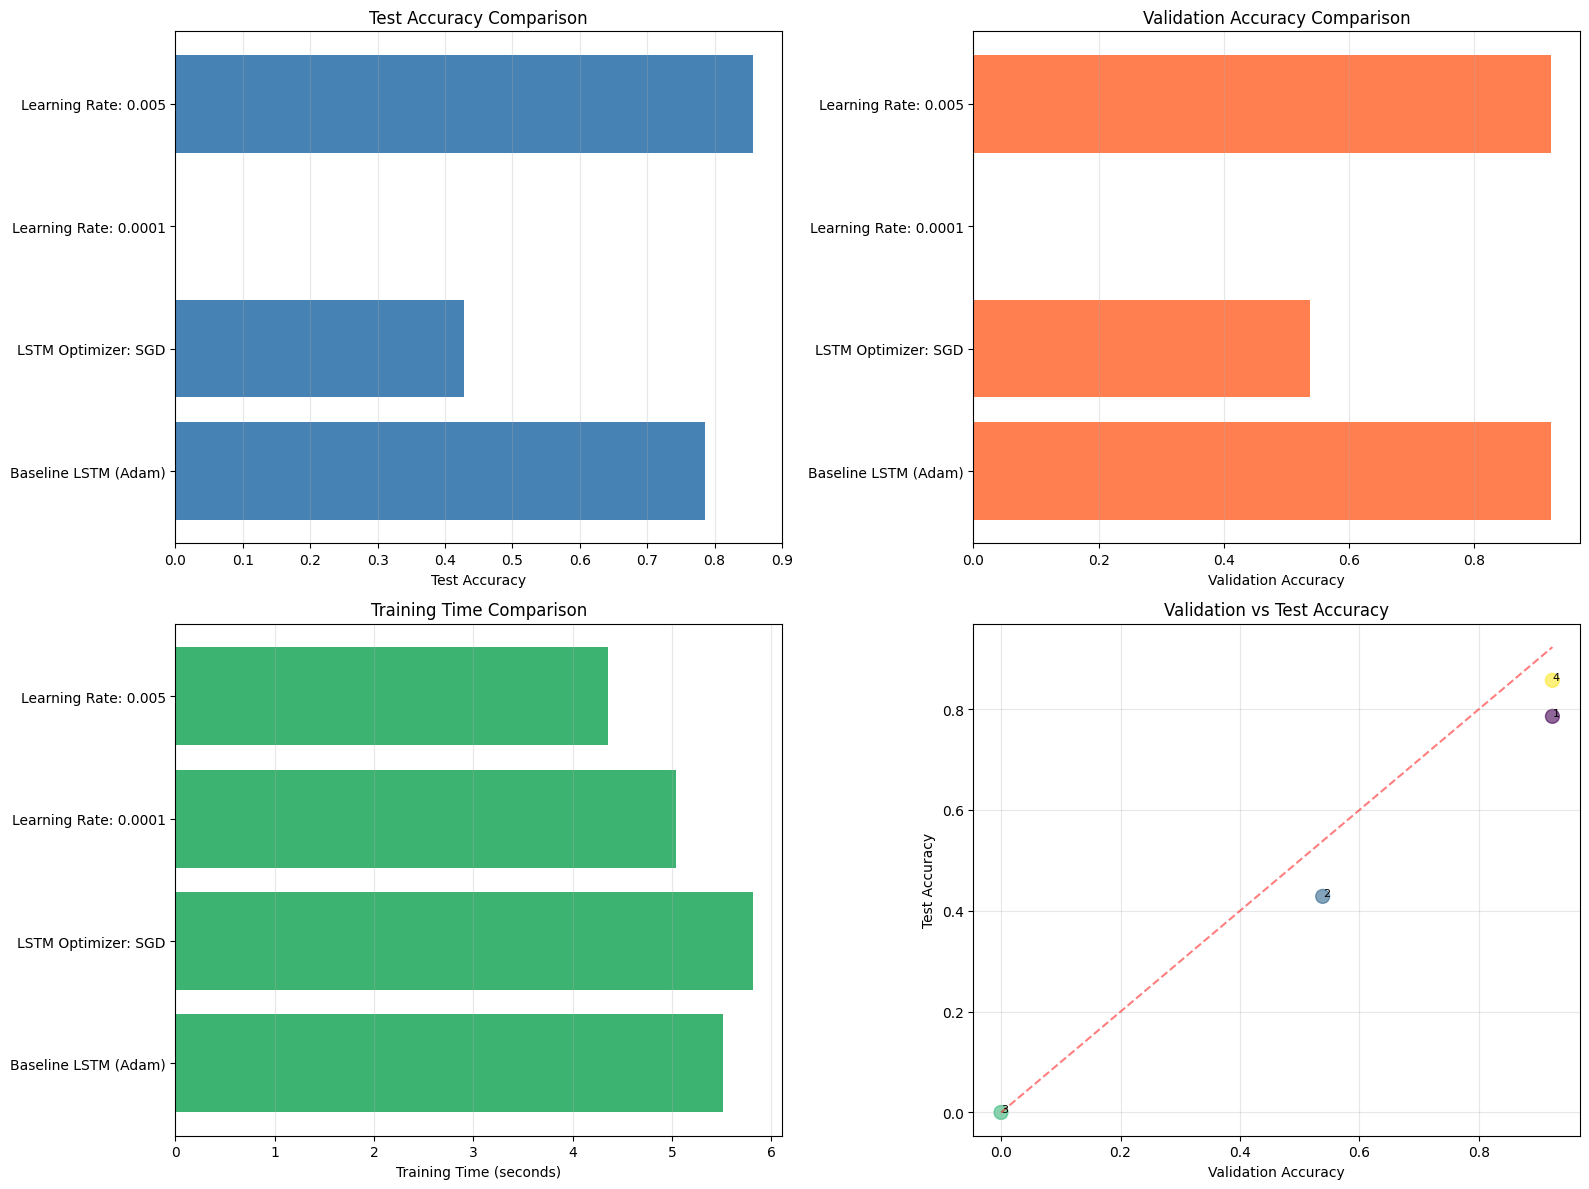

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
test_accs = [float(r['test_acc']) for r in experiment_results]
exp_names = [r['experiment_name'] for r in experiment_results]
axes[0, 0].barh(exp_names, test_accs, color='steelblue')
axes[0, 0].set_xlabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy Comparison')
axes[0, 0].grid(axis='x', alpha=0.3)
# 2. Validation Accuracy Comparison
val_accs = [float(r['best_val_acc']) for r in experiment_results]
axes[0, 1].barh(exp_names, val_accs, color='coral')
axes[0, 1].set_xlabel('Validation Accuracy')
axes[0, 1].set_title('Validation Accuracy Comparison')
axes[0, 1].grid(axis='x', alpha=0.3)
# 3. Training Time Comparison
train_times = [r['training_time'] for r in experiment_results]
axes[1, 0].barh(exp_names, train_times, color='mediumseagreen')
axes[1, 0].set_xlabel('Training Time (seconds)')
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].grid(axis='x', alpha=0.3)
# 4. Val vs Test Accuracy
axes[1, 1].scatter(val_accs, test_accs, s=100, alpha=0.6, c=range(len(exp_names)), cmap='viridis')
for i, name in enumerate(exp_names):
    axes[1, 1].annotate(str(i+1), (val_accs[i], test_accs[i]), fontsize=8)
axes[1, 1].plot([min(val_accs), max(val_accs)], [min(val_accs), max(val_accs)], 'r--', alpha=0.5)
axes[1, 1].set_xlabel('Validation Accuracy')
axes[1, 1].set_ylabel('Test Accuracy')
axes[1, 1].set_title('Validation vs Test Accuracy')
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()

## 8. Conclusions and Insights

### Key Findings:

1. **Optimizer Comparison:**
   - Compare the performance of Adam, SGD, and RMSprop optimizers
   - Analyze convergence speed and final accuracy

2. **Learning Rate Impact:**
   - Effect of learning rate on training stability and convergence
   - Optimal learning rate for the exercise classification task

3. **Batch Size Impact:**
   - Trade-off between batch size and training time
   - Effect on generalization performance

4. **Model Capacity:**
   - Impact of number of filters on model performance
   - Effect of kernel size on feature extraction

5. **Best Configuration:**
   - The configuration that achieved the highest test accuracy
   - Recommended hyperparameters for production use


In [ ]:
import json
save_results = []
for result in experiment_results:
    save_results.append({
        'experiment_name': result['experiment_name'],
        'config': result['config'],
        'best_val_acc': float(result['best_val_acc']),
        'test_acc': float(result['test_acc']),
        'training_time': float(result['training_time']),
        'final_train_loss': float(result['history']['train_loss'][-1]),
        'final_val_loss': float(result['history']['val_loss'][-1])
    })
with open('experiment_results.json', 'w') as f:
    json.dump(save_results, f, indent=2)
print("Experiment results saved to 'experiment_results.json'")
print("\nNotebook execution complete! ✅")

Experiment results saved to 'experiment_results.json'

Notebook execution complete! ✅


In [ ]:
# --- Data Integrity Check for LSTM Inputs ---
import torch
def check_tensor_integrity(tensor, name):
    print(f"Checking {name}:")
    print(f"  Shape: {tensor.shape}")
    print(f"  Contains NaN: {torch.isnan(tensor).any().item()}")
    print(f"  Min value: {tensor.min().item()}")
    print(f"  Max value: {tensor.max().item()}")
    print(f"  Mean value: {tensor.mean().item()}")
    print()
check_tensor_integrity(X_train_tensor, 'X_train_tensor')
check_tensor_integrity(X_val_tensor, 'X_val_tensor')
check_tensor_integrity(X_test_tensor, 'X_test_tensor')

Checking X_train_tensor:
  Shape: torch.Size([63, 61, 44])
  Contains NaN: False
  Min value: -1160.0
  Max value: 1440.0
  Mean value: 21.319347381591797

Checking X_val_tensor:
  Shape: torch.Size([13, 61, 44])
  Contains NaN: False
  Min value: -725.0
  Max value: 906.0
  Mean value: 25.948427200317383

Checking X_test_tensor:
  Shape: torch.Size([14, 61, 44])
  Contains NaN: False
  Min value: -730.0
  Max value: 1040.0
  Mean value: 25.985321044921875



In [66]:
# Print overall (best) test accuracy from summary table (clean formatting)
best_idx = summary_df['Test Accuracy'].astype(float).idxmax()
overall_test_acc = summary_df.iloc[best_idx]['Test Accuracy']
print(f'Overall (Best) Test Accuracy: {overall_test_acc}')

Overall (Best) Test Accuracy: 0.8571


In [67]:
# --- Diagnose Experiment with 0% Test Accuracy ---
zero_acc_experiments = [r for r in experiment_results if float(r['test_acc']) == 0.0]
if zero_acc_experiments:
    for idx, exp in enumerate(zero_acc_experiments):
        print(f"\n{'='*40}")
        print(f"Experiment with 0% Test Accuracy #{idx+1}")
        print(f"Name: {exp['experiment_name']}")
        print(f"Config: {exp['config']}")
        print(f"Training Time: {exp['training_time']:.2f} seconds")
        print(f"Best Validation Accuracy: {exp['best_val_acc']*100:.2f}%")
        print(f"Final Training Loss: {exp['history']['train_loss'][-1]:.4f}")
        print(f"Final Validation Loss: {exp['history']['val_loss'][-1]:.4f}")
        print(f"Training Accuracy Curve: {exp['history']['train_acc']}")
        print(f"Validation Accuracy Curve: {exp['history']['val_acc']}")
        print(f"Classification Report:\n{exp['test_report']}")
        print(f"Confusion Matrix:\n{exp['test_cm']}")
else:
    print("No experiments with 0% test accuracy found.")


Experiment with 0% Test Accuracy #1
Name: Learning Rate: 0.0001
Config: {'optimizer': 'Adam', 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 50, 'dropout_rate': 0.5}
Training Time: 5.04 seconds
Best Validation Accuracy: 0.00%
Final Training Loss: 1.6105
Final Validation Loss: 1.6199
Training Accuracy Curve: [0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.06349206349206349, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744, 0.031746031746031744